<a href="https://colab.research.google.com/github/ahorvath008/Data-Science/blob/master/Car_Price_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Purpose:** The purpose of the following analysis is to analyse variables impacting the purchase price of cars. It also provides a model to predict the price of cars. 

**Data:** The data source is the car sales database from the US (from Kaggle) 

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a href="#data_acquisition">Data import and data wrangling</a>
    <li><a href="#basic_insight">Data characteristics</a></li>
    <li><a href=""#basic_insight"> Exploratory Data Analysis (EDA) </a></li>
    <li><a href="#basic_insight">Model building and regression</a></li>
    <li><a href="#basic_insight">Data visualisations and graphs</a></li>
 </ol>

</div>
<hr>

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [ ]:
# Read the online car price file 
other_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/auto.csv"
df = pd.read_csv(other_path, header=None)

In [ ]:
#1. Data import and data wrangling
# Get an overview of the dataframe columns
df.head(5)

In [ ]:
# create headers list to make the data more readable and easier to understand
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]
print("headers\n", headers)
df.columns = headers

In [ ]:
# The data for objects (i.e. non-numeric values) can also be obtained.
df.describe()

In [ ]:
# Rename the "symboling" column to "insurance risk" to make the data more user-friendly
df.rename(columns={'symboling':'insurance_risk'}, inplace=True)

In [ ]:
#Need to drop the height column as we do not use this for this analysis
df.drop(["height"],axis=1,inplace=True)
df.describe()

In [ ]:
#2. Data characteristics
#Need to check how many missing values we have for prices
print("Number of missing values for prices", df['price'].isnull().sum())

In [ ]:
# Need to replace the ? in the files so that these can then later be dropped and check that this worked
df=df.replace('?',np.NaN)
df.info()

In [ ]:
# The price column is an object and should be an int variable instead.  We need to convert and then check the dataframe info
df["price"] = df["price"].astype("float")

In [ ]:
# The horsepower column is an object and should be an int variable instead.  We need to convert and then check the dataframe info
df["horsepower"] = df["horsepower"].astype("float")
df.info()

In [ ]:
# We replace the empty prices with the average prices
avg_price = df["price"].mean(axis=0)
print(avg_price)
df["price"].replace(np.nan, avg_price, inplace=True)
df.head(5)

In [ ]:
# We replace the empty horsepower with the average horsepower
avg_horsepower = df["horsepower"].mean(axis=0)
print(avg_horsepower)
df["horsepower"].replace(np.nan, avg_horsepower, inplace=True)

In [ ]:
# For normalized-losses, we will set these values to float. 
avg_norm_loss = df["normalized-losses"].astype("float").mean(axis=0)
print(avg_norm_loss)
#Now replace the Normalized Losses non-values with the Average value of the NL. 
df["normalized-losses"].replace(np.nan, avg_norm_loss, inplace=True)
df.head(5)

In [ ]:
# Some of the key data needs to be normalised (divide each value by the max value of that series)
df["length"] = df["length"]/df["length"].max()
df["width"] = df["width"]/df["width"].max()

In [ ]:
# Obtain statistics for one specific column, for instance price
df['price'].describe() 

In [ ]:
# Now we can drop all the entries that do not have a price data
df.dropna(subset=["price"], axis=0, inplace=True)

In [ ]:
# We can check the drive wheels column before we wish to group the data, so that we can identify what to group them by:
df['drive-wheels'].unique()

In [ ]:
# Group the data and look at average price based on key characterisitcs. We need to use the groupby function, on categorical variables 
df_test = df[['drive-wheels', 'body-style', 'price']]
df_grp = df_test.groupby(['drive-wheels', 'body-style'], as_index=False).mean()
df_grp.rename(columns={'price':'average price'}, inplace=True)
df_grp

In [ ]:
# Using the pivot method to create a pivot table to summarise the data and fill in with 0 where there is no data. 
df_pivot = df_grp.pivot(index='drive-wheels', columns='body-style')
df_pivot = df_pivot.fillna(0)
df_pivot

In [ ]:
#In case we need to use a numeric value of fuel types, we create a dummy variable and dataframe to show these
dummy_variable_1 = pd.get_dummies(df["fuel-type"])
dummy_variable_1.head()

# Once done, we need to concetenate the dummy_variable df with our initial df as follows:
df = pd.concat([df, dummy_variable_1], axis=1)
df.head(5)

In [ ]:
# We perform a binning operation to show the horsepower as low/high/medium as opposed to the actual value.  

bins = np.linspace(min(df["horsepower"]), max(df["horsepower"]), 4)  
# We first create 3 bins (low/medium/high) using numpy's linspace command
bins

# We then create the 3 bins
group_names=["Low", "Medium", "High"]

# We use the Cut function to assign the different horsepowers into the individual bins
df['horsepower-binned'] = pd.cut(df['horsepower'], bins, labels=group_names, include_lowest=True)
df[['horsepower','horsepower-binned']].head(20)
df["horsepower-binned"].value_counts()

# Run basic statistics on the cleaned-up data.  Note the added horsepower-binned field
df.head(5)

In [ ]:
#3. Data Queries and Statistical Analysis
#Which ones are the the most popular car makes?
df['make'].value_counts()

In [ ]:
#Which cars have the largest horsepower?
df.sort_values(by='horsepower', ascending=False)

In [ ]:
#What is the breakdown of the number of cars per wheel type? This can help assess if any value may not be statistically important
df['drive-wheels'].value_counts()
#Convert this into a dataframe
df['drive-wheels'].value_counts().to_frame()

In [ ]:
#Which variable has the largest correlation with car prices?
df.corr()['price'].sort_values()

In [ ]:
#We can calculate the correlation stats between the variables using the following format
df[['engine-size', 'horsepower']].corr()

In [ ]:
#We can calculate the correlation stats between the variables using the following format
df[['highway-mpg', 'price']].corr()

In [ ]:
#Correlation statistics between continuous numerical variables
#1. Correlation coefficient (-1 to +1) (Pearson Coefficient)
#2. Pearson Correlation Method (How confident are we in the correlation results); #p-value < 0.001 strong certainty, >0.1 no certainty
pearson_coef, p_value = pearsonr(df['horsepower'],df['price'])
print(pearson_coef, p_value)

#As the p_value is much smaller than 0.001, we are confident that the correlation results are reliable

In [ ]:
#ANOVA (Analysis of Variance) statistics (F-value and p-value) are used to check correlation between different groups of categorical 
#variables by testing whether there are significant differences between the means of two or more groups. 
#ANOVA returns two parameters: F-test score: ANOVA assumes the means of all groups are the same, calculates 
#how much the actual means deviate from the assumption, and reports it as the F-test score. 
# A larger score means there is a larger difference between the means.

df_anova = df[["make", "price"]]
grouped_anova = df_anova.groupby(["make"])

anova_results_1 = stats.f_oneway(grouped_anova.get_group("honda") ["price"], grouped_anova.get_group("subaru") ["price"])
print(anova_results_1)
# As f-score is less than 1 and p is larger than 0.5, there is no significant difference between prices

anova_results_2 = stats.f_oneway(grouped_anova.get_group("honda") ["price"], grouped_anova.get_group("jaguar") ["price"])
print(anova_results_2)
# As f-score is large, there is a strong correlation, and as p is very small, the correlation is reliable. 

In [ ]:
#4. Model building and regression
#   Simple Linear Regression (one independent variable)

from sklearn.linear_model import LinearRegression 
#We first define a predictor and target variable
lm=LinearRegression()
x = df[['highway-mpg']]
y = df[['price']]

lm.fit(x,y)
#We can then obtain a prediction
#yhat = lm.predict(x)
yhat = lm.predict(np.array(30).reshape(-1,1))
print("yhat equals", yhat)
#We can view the intercept (b0)
print(lm.intercept_)

#We can view the slope (b1)
print(lm.coef_)

#We can then build our model as follows:
# "Price" = 37470 - 789* "highway-mpg"

#R2 score
lm.score(x,y)

yhat equals [[13799.86154571]]
[37470.66014138]
[[-789.02661986]]


0.47682578947968446

In [ ]:
#   Multiple Linear Regression (multiple independent variables)

from sklearn.linear_model import LinearRegression 
z = df[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']]

#Train the model
lm.fit(z,df['price'])

#Obtain a prediction
yhat = lm.predict(z)

#We can view the intercept (b0)
print(lm.intercept_)

#We can view the slope (b1)
print(lm.coef_)

#We can then build our model as follows:
# Price = -9239. +18.1 * "Horsepower" + 3.8 * "Curb-weight" + 101.1 * engine size - 65.1 * "highway-mpg"

#R2 score
lm.score(z,y)

-9239.379970934518
[ 18.12178086   3.80596513 101.121117   -65.10968116]


0.7762109132723989

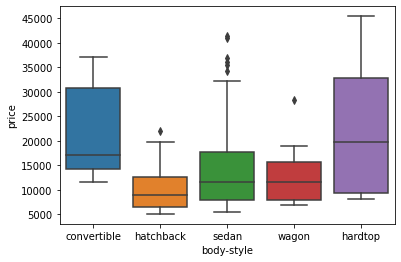

In [ ]:
#5. Data visualisations and graphs
#Boxplots are a good way to visualise categorical variables
sns.boxplot(x="body-style", y="price", data=df)
#Important to note: We see that the distributions of price between the different body-style categories have a significant overlap, and so body-style would not be a good predictor of price

Text(0.5, 1.0, 'horsepower totals')

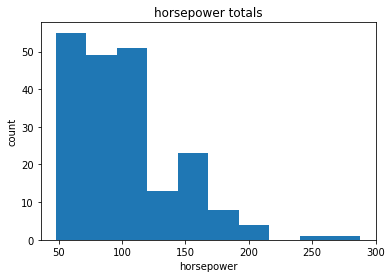

In [ ]:
# Graph out critical horsepower data and set x/y labels.  This indicates most cars in the dataset are between 50-100 horsepower
plt.pyplot.hist(df["horsepower"])
plt.pyplot.xlabel("horsepower")
plt.pyplot.ylabel("count")
plt.pyplot.title("horsepower totals")

Text(0.5, 1.0, 'horsepower bins')

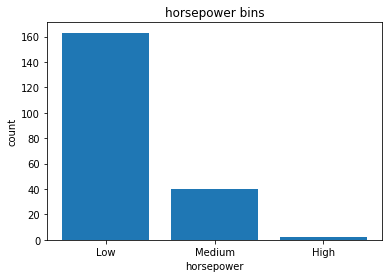

In [ ]:
# Graph out the distribution of each bin
pyplot.bar(group_names, df["horsepower-binned"].value_counts())
plt.pyplot.xlabel("horsepower")
plt.pyplot.ylabel("count")
plt.pyplot.title("horsepower bins")

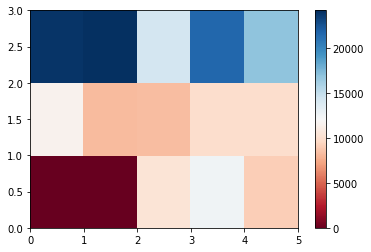

In [ ]:
# Heatmap is a good way to put a pivot table in a graphical format
#ax = plt.pyplot.subplots()
plt.pyplot.pcolor(df_pivot, cmap='RdBu')
plt.pyplot.colorbar()
plt.pyplot.show()
#row_labels = df_pivot.columns.levels[1]
#col_labels = df_pivot.index
#ax.set_xticklabels(row_labels, minor=False)
#ax.set_yticklabels(col_labels, minor=False)

Text(0, 0.5, 'Price')

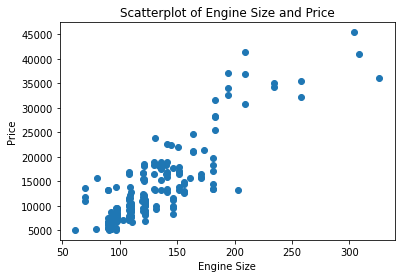

In [ ]:
# Use a scatterplot to see if price is determined by engine size.  Based on the graph, it looks like there is a positive relationship
y = df["price"]
x = df["engine-size"]
plt.pyplot.scatter(x,y)

plt.pyplot.title("Scatterplot of Engine Size and Price")
plt.pyplot.xlabel("Engine Size")
plt.pyplot.ylabel("Price")

(0.0, 52273.760759894736)

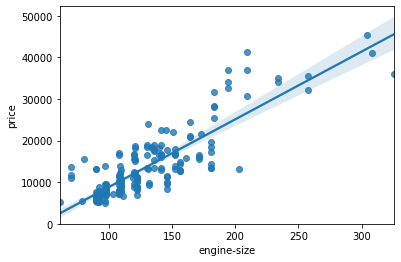

In [ ]:
#Based on the above and the regression model, graphically fit the line. 
sns.regplot(x="engine-size", y="price", data=df)
plt.pyplot.ylim(0,)

Text(0, 0.5, 'Price')

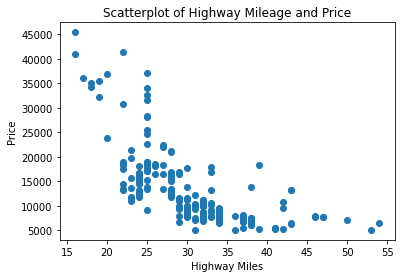

In [ ]:
# Use a scatterplot to see if price is determined by highway miles.  Based on the graph, it looks like there is a negative relationship
y = df["price"]
x = df["highway-mpg"]
plt.pyplot.scatter(x,y)

plt.pyplot.title("Scatterplot of Highway Mileage and Price")
plt.pyplot.xlabel("Highway Miles")
plt.pyplot.ylabel("Price")

(0.0, 48120.51568172065)

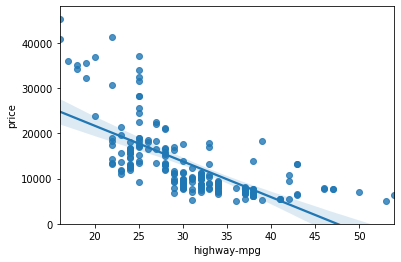

In [ ]:
#Based on the above and the regression model, graphically fit the line. 
sns.regplot(x="highway-mpg", y="price", data=df)
plt.pyplot.ylim(0,)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


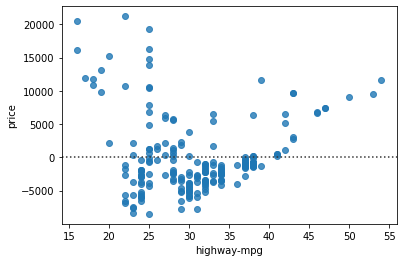

In [ ]:
#A residual plot shows a curvature, therefore the residual errors are not evenly distributed and therefore the linear assumption is not correct
sns.residplot(df["highway-mpg"], df["price"])